# Case study: Row-Column Addressed Matrix Probe

## Row-Column Addressed probes

Dimensions: 
- OX - azimuth (elements)
- OY - elevation (elements)
- OZ - depth

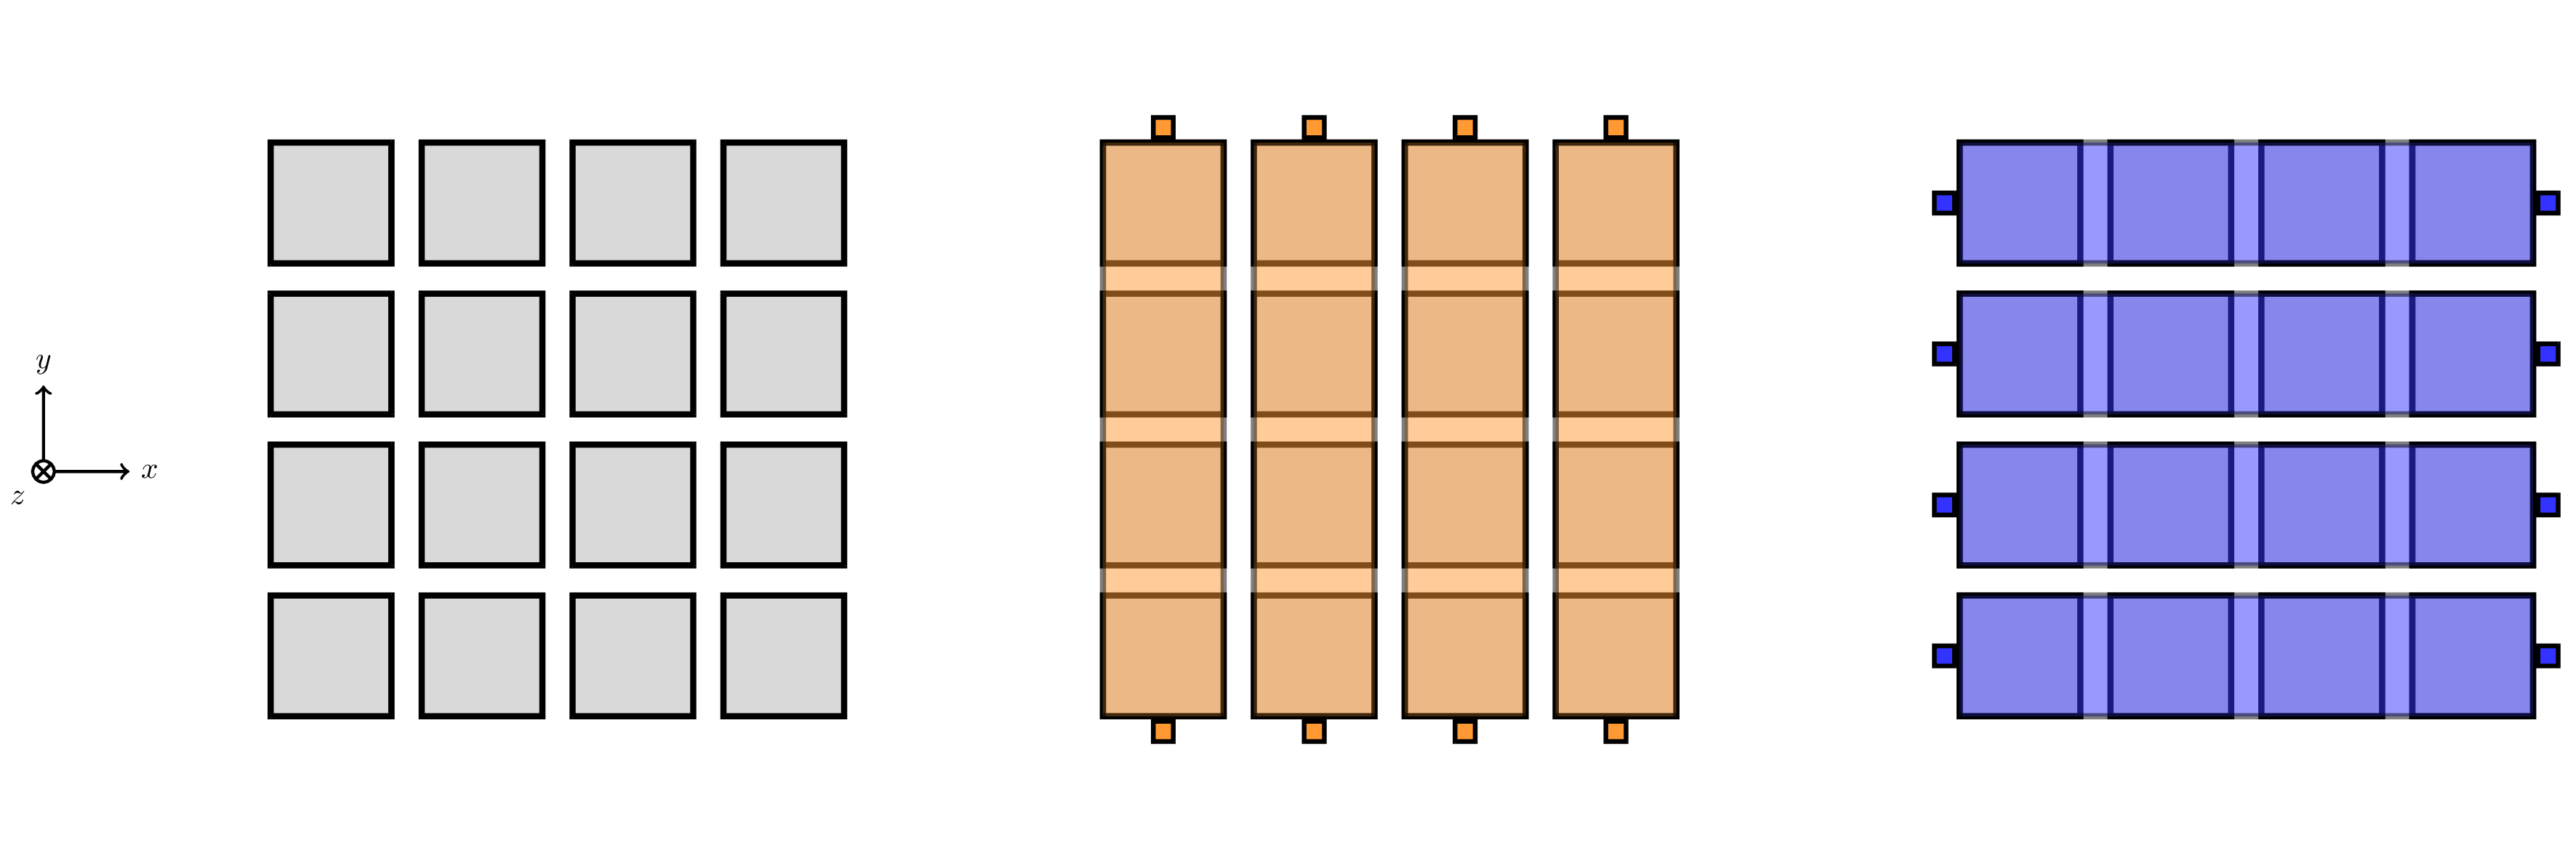

## Plane Wave Imaging with RCA

## Imaging Reconstruction on NVIDIA GPU

### Volume Data visualization

### Implementation 

### Testing on simulated data

### Testing on actual raw channel data

## References